#Huff_Week7_Assignment7 -- ANN classification of Digit Images

#INGRESS

In [ ]:
# import libraries
import pandas as pd
from pandas.core.series import Series

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sys
#import statsmodels.api as sm
import math
import random

from sklearn.model_selection import train_test_split
from matplotlib.pyplot import figure

#from sklearn.naive_bayes import GaussianNB
#from sklearn.linear_model import LogisticRegression
#from sklearn.utils import shuffle
 
#from sklearn.model_selection import GridSearchCV
#from sklearn.linear_model import SGDClassifier
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.ensemble import RandomForestRegressor
#from sklearn.model_selection import RandomizedSearchCV
#from sklearn.ensemble import GradientBoostingClassifier
#from sklearn.ensemble import BaggingClassifier
#from sklearn.ensemble import ExtraTreesClassifier

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
#from sklearn.metrics import zero_one_loss

#from sklearn.metrics import roc_curve, auc
#from sklearn.metrics import confusion_matrix

#import pylab
#from pylab import hist, show, xticks
#from sklearn.cluster import KMeans
#from scipy.spatial.distance import cdist
#from scipy import optimize
#from scipy import interpolate
#from numpy.linalg import lstsq
#from sklearn.linear_model import LinearRegression
#from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

from sklearn.neural_network import MLPClassifier

#from pprint import pprint
#from datetime import datetime

In [ ]:
# get training data
from google.colab import files
upload = files.upload()

Saving train.csv to train.csv


# EDA and MODELING

**Prepare the training data and create PCA components to be the features**

In [ ]:
# convert inputted data into dataframe
origDF = pd.read_csv('train.csv')

# extract response variable ('label') from dataset
yDF = origDF['label']
Xdf = origDF.copy()
Xdf = Xdf.drop(columns=['label'], axis=1)

# zero-mean the data
Xdf_zeroMean = Xdf - np.mean(Xdf, axis=0)

# calculate the covariance matrix of the mean-centered data.
cov_mat = np.cov(Xdf_zeroMean, rowvar = False)

# calculate eigenvalues & eigenvectors and eliminate any imag components
eigVals, eigVects = np.linalg.eig(cov_mat)
eigVals = eigVals.real
eigVects = eigVects.real

# sort the eigenvalues in descending order
eigValSortedIndex = np.argsort(eigVals)[::-1]
eigVals_sorted = eigVals[eigValSortedIndex]

# sort the eigenvectors 
eigVects_sorted = eigVects[:, eigValSortedIndex]

# calculate the explained variances based upon eigenvalues
explainedVariances = []
for aa in range(len(eigVals)):
    explainedVariances.append(eigVals_sorted[aa] / np.sum(eigVals_sorted))

# plot the cumulative sum of the explained variances
explainedVariances = Series(explainedVariances)
explainVarCumSum = explainedVariances.cumsum()
pcaIndex = np.arange(1,len(explainedVariances)+1)

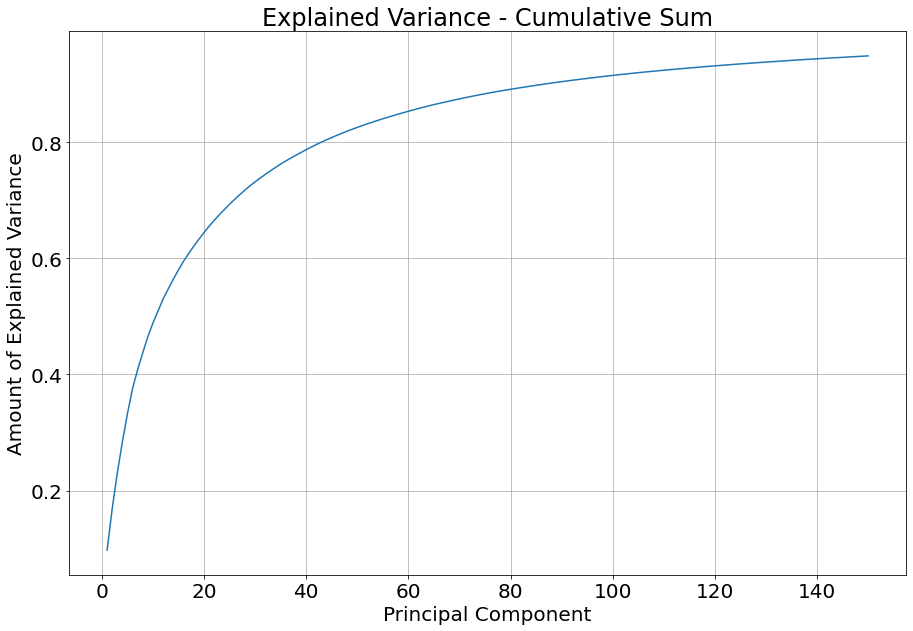

In [ ]:
PC_MAX = 150  # maximum number of principle components to consider

# plot the cumulative sums
fig = plt.figure(figsize=(15, 10))
plt.rcParams["font.size"] = '20'
plt.title("Explained Variance - Cumulative Sum")
plt.xlabel("Principal Component")
plt.ylabel("Amount of Explained Variance")
plt.plot(pcaIndex[:PC_MAX], explainVarCumSum[:PC_MAX])
plt.grid()

In [ ]:
# recheck how many principal components are need to explain 95% of the variance
print('The explained variances at about 120 principal components are:')
for aa in [150,151,152,153,154,155]:
  print('For principal component number',aa,'..., the explained variance =', explainVarCumSum[aa-1])

The explained variances at about 120 principal components are:
For principal component number 150 ..., the explained variance = 0.948598486622723
For principal component number 151 ..., the explained variance = 0.9490637832968537
For principal component number 152 ..., the explained variance = 0.9495251455550341
For principal component number 153 ..., the explained variance = 0.9499814820553452
For principal component number 154 ..., the explained variance = 0.9504332382633774
For principal component number 155 ..., the explained variance = 0.950882726845245


In [ ]:
# create dataframe consisting of first 150 principal components
eigVects_subset = eigVects_sorted[:, 0:PC_MAX]

# transform the data 
Xpca = pd.DataFrame(np.dot(eigVects_subset.transpose(),Xdf_zeroMean.transpose()).transpose())

# min-max the PCA-transformed data
scaler = MinMaxScaler(feature_range=(0, 1))
names = Xpca.columns
d = scaler.fit_transform(Xpca)
scaled_Xpca = pd.DataFrame(d, columns=names)
scaled_Xpca.describe()

,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
count,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,...,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000
mean,0.310305,0.488220,0.510894,0.507045,0.486229,0.507705,0.467718,0.474397,0.582365,0.496064,...,0.509911,0.528060,0.490857,0.454834,0.538849,0.460816,0.483870,0.519334,0.466996,0.500111
std,0.166998,0.171063,0.159608,0.139422,0.155500,0.153267,0.140669,0.139799,0.117726,0.138738,...,0.112234,0.104982,0.099018,0.093806,0.115130,0.099416,0.101861,0.094073,0.097225,0.113642
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.194324,0.362072,0.400290,0.419260,0.381915,0.400533,0.366603,0.379710,0.502383,0.406545,...,0.438438,0.460515,0.428003,0.394017,0.465053,0.397716,0.418503,0.458798,0.405296,0.425464
50%,0.294532,0.460165,0.505440,0.505174,0.490138,0.504232,0.461277,0.461242,0.588256,0.501686,...,0.510825,0.528702,0.490020,0.453842,0.539667,0.459891,0.483108,0.519303,0.467481,0.499314
75%,0.407421,0.620506,0.624442,0.606855,0.592050,0.613074,0.563184,0.562803,0.666941,0.593524,...,0.582685,0.595077,0.552831,0.513662,0.613870,0.523141,0.549566,0.579427,0.529951,0.572725
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


**Split the PCA-transformed data into training and validation datasets**

In [ ]:
# split into training and validation datasets
trainDF, valDF, yTrain, yVal = train_test_split(scaled_Xpca, yDF, test_size = 0.2, random_state = 42)

-------------------------------------------------------

**Prepare the test data set**

In [ ]:
# load test.csv data
from google.colab import files
upload = files.upload()

Saving test.csv to test.csv


In [ ]:
# convert inputted data into dataframe
testDF = pd.read_csv('test.csv')

# zero-mean the test data
Xtest_zeroMean = testDF - np.mean(testDF, axis=0)

# calculate the covariance matrix of the mean-centered data.
cov_mat_test = np.cov(Xtest_zeroMean, rowvar = False)

# calculate the eigenvalues and eigenvectors
eigVals_test, eigVects_test = np.linalg.eig(cov_mat_test)

# use the real component
eigVals_test_real = eigVals_test.real
eigVects_test_real = eigVects_test.real

# sort the eigenvalues in descending order
eigValSortedIndex_test = np.argsort(eigVals_test_real)[::-1]
eigValsTest_sorted = eigVals_test_real[eigValSortedIndex_test]

# sort the eigenvectors 
eigVectsTest_sorted = eigVects_test_real[:, eigValSortedIndex_test]

# calculate the explained variances based upon eigenvalues
explainedVariancesTest = []
for aa in range(len(eigValsTest_sorted)):
    explainedVariancesTest.append(eigValsTest_sorted[aa] / np.sum(eigValsTest_sorted))

# plot the cumulative sum of the explained variances
explainedVariancesTest = Series(explainedVariancesTest)
explainVarCumSumTest = explainedVariancesTest.cumsum()
pcaIndexTest = np.arange(1,len(explainedVariancesTest)+1)

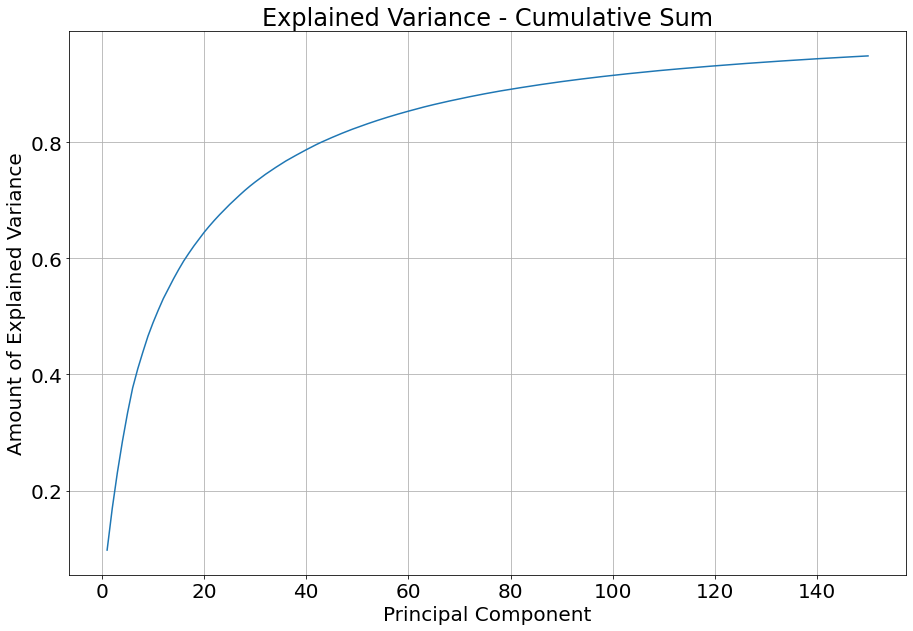

In [ ]:
PC_MAX_TEST = PC_MAX  # maximum number of principle components to consider

# plot the cumulative sums
fig = plt.figure(figsize=(15, 10))
plt.rcParams["font.size"] = '20'
plt.title("Explained Variance - Cumulative Sum")
plt.xlabel("Principal Component")
plt.ylabel("Amount of Explained Variance")
plt.plot(pcaIndexTest[:PC_MAX_TEST], explainVarCumSumTest[:PC_MAX_TEST])
plt.grid()

In [ ]:
# create dataframe consisting of first 150 principal components
eigVectsTest_subset = eigVectsTest_sorted[:, 0:PC_MAX]

# transform the data 
Xpca_test = pd.DataFrame(np.dot(eigVectsTest_subset.transpose(),Xtest_zeroMean.transpose()).transpose())

# min-max the PCA-transformed data
scaler = MinMaxScaler(feature_range=(0, 1))
names = Xpca_test.columns
d = scaler.fit_transform(Xpca_test)
scaled_Xpca_test = pd.DataFrame(d, columns=names)
scaled_Xpca_test.describe()

,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
count,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,...,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000
mean,0.682613,0.506752,0.494566,0.509714,0.485106,0.501672,0.563154,0.509138,0.456597,0.492920,...,0.467044,0.470448,0.533667,0.470493,0.462787,0.495235,0.500521,0.493845,0.509236,0.472586
std,0.168694,0.177493,0.159209,0.138935,0.150582,0.158091,0.151554,0.135247,0.130866,0.146818,...,0.092697,0.100530,0.096282,0.100849,0.091152,0.108908,0.109282,0.105232,0.102577,0.103367
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.585507,0.376981,0.381760,0.421606,0.382702,0.392643,0.462002,0.424151,0.364023,0.389082,...,0.407822,0.406222,0.472213,0.406217,0.405063,0.426252,0.429442,0.426859,0.445113,0.406488
50%,0.694973,0.477090,0.501172,0.508623,0.488280,0.495879,0.571595,0.522775,0.451480,0.486149,...,0.466997,0.470605,0.535418,0.469891,0.462670,0.495125,0.501593,0.493483,0.509123,0.472010
75%,0.798106,0.645041,0.605855,0.609940,0.587953,0.608770,0.669726,0.599320,0.545024,0.585033,...,0.525515,0.534039,0.596322,0.533835,0.520460,0.563778,0.572148,0.561877,0.574340,0.538128
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


=====================================================================================================

**Create for loop to train and test four different neural networks (training and validation datasets)**

In [ ]:
HIDDEN_LAYERS = [ (64,),(128,), (32,64),(64,128) ]

trainLossCurve = [ [],[],[],[] ]
trainScore = [0] * len(HIDDEN_LAYERS)
trainAccuracy = [0] * len(HIDDEN_LAYERS)

valScore = [0,0,0,0]
valAccuracy = [0,0,0,0]
 
# train and test each MLP version
for mlpNo in range(len(HIDDEN_LAYERS)):

  hlSizes = HIDDEN_LAYERS[mlpNo]
  nLayers = len(hlSizes)
  isAre = 'is'
  layerSingularPlural = 'layer'
  if nLayers > 1:
    isAre = 'are'
    layerSingularPlural = layerSingularPlural + 's'

  print('\nThere', isAre, nLayers, 'hidden', layerSingularPlural, 'in MLP number', mlpNo+1)
  print('The number of nodes in the hidden', layerSingularPlural, 'are', hlSizes)

  # initialize the MLPClassifier
  classifier = MLPClassifier(hidden_layer_sizes=(hlSizes), max_iter=1000, activation = 'relu', solver='adam', random_state=1)

  # fit the training data to the network
  classifier.fit(trainDF, yTrain)
  trainLossCurve[mlpNo] = list(classifier.loss_curve_)

  # predict using train data
  yTrainPred = classifier.predict(trainDF)
  trainScore[mlpNo] = classifier.score(trainDF, yTrain)
  #trainAccuracy[mlpNo] = np.mean(yTrain-yTrainPred)
  trainAccuracy[mlpNo] = metrics.accuracy_score(yTrain, yTrainPred)

  # predict using validation data
  yValPred = classifier.predict(valDF)
  valScore[mlpNo] = classifier.score(valDF, yVal)
  #valAccuracy[mlpNo] = np.mean(yVal-yTrainPred)
  valAccuracy[mlpNo] = metrics.accuracy_score(yVal, yValPred)


There is 1 hidden layer in MLP number 1
The number of nodes in the hidden layer are (64,)

There is 1 hidden layer in MLP number 2
The number of nodes in the hidden layer are (128,)

There are 2 hidden layers in MLP number 3
The number of nodes in the hidden layers are (32, 64)

There are 2 hidden layers in MLP number 4
The number of nodes in the hidden layers are (64, 128)


In [ ]:
print('\nTraining data, prediction accuracy of MLP #1 (1 hidden layer, 64 nodes) =', trainAccuracy[0])
print('Validation data, prediction accuracy of MLP #1 (1 hidden layer, 64 nodes) =', valAccuracy[0])

print('\nTraining data, prediction accuracy of MLP #2 (1 hidden layer, 128 nodes) =', trainAccuracy[1])
print('Validation data, prediction accuracy of MLP #2 (1 hidden layer, 128 nodes) =', valAccuracy[1])

print('\nTraining data, prediction accuracy of MLP #3 (2 hidden layers, 64 & 32 nodes) =', trainAccuracy[2])
print('Validation data, prediction accuracy of MLP #3 (2 hidden layers, 64 & 32 nodes) =', valAccuracy[2])

print('\nTraining data, prediction accuracy of MLP #4 (2 hidden layers, 128 & 64 nodes) =', trainAccuracy[3])
print('Validation data, prediction accuracy of MLP #4 (2 hidden layers, 128 & 64 nodes) =', valAccuracy[3])


Training data, prediction accuracy of MLP #1 (1 hidden layer, 64 nodes) = 0.9764880952380952
Validation data, prediction accuracy of MLP #1 (1 hidden layer, 64 nodes) = 0.9494047619047619

Training data, prediction accuracy of MLP #2 (1 hidden layer, 128 nodes) = 0.9996726190476191
Validation data, prediction accuracy of MLP #2 (1 hidden layer, 128 nodes) = 0.9595238095238096

Training data, prediction accuracy of MLP #3 (2 hidden layers, 64 & 32 nodes) = 0.9861607142857143
Validation data, prediction accuracy of MLP #3 (2 hidden layers, 64 & 32 nodes) = 0.9569047619047619

Training data, prediction accuracy of MLP #4 (2 hidden layers, 128 & 64 nodes) = 0.9906547619047619
Validation data, prediction accuracy of MLP #4 (2 hidden layers, 128 & 64 nodes) = 0.9563095238095238


--------------------------------------------------------

In [ ]:
# repeat the above for loop, but reverse the order of the hidden layers in the 2-layer MLPs

HIDDEN_LAYERS = [ (64,),(128,), (64,32),(128,64) ]

trainLossCurve = [ [],[],[],[] ]
trainScore = [0] * len(HIDDEN_LAYERS)
trainAccuracy = [0] * len(HIDDEN_LAYERS)

valScore = [0,0,0,0]
valAccuracy = [0,0,0,0]
 
# train and test each MLP version
for mlpNo in range(len(HIDDEN_LAYERS)):

  hlSizes = HIDDEN_LAYERS[mlpNo]
  nLayers = len(hlSizes)
  isAre = 'is'
  layerSingularPlural = 'layer'
  if nLayers > 1:
    isAre = 'are'
    layerSingularPlural = layerSingularPlural + 's'

  print('\n======================================================================================================\n')
  print('There', isAre, nLayers, 'hidden', layerSingularPlural, 'in MLP number', mlpNo+1)
  print('The number of nodes in the hidden', layerSingularPlural, 'are', hlSizes)

  # initialize the MLPClassifier
  classifier = MLPClassifier(hidden_layer_sizes=(hlSizes), max_iter=2000, activation = 'relu', solver='adam', random_state=1)

  # fit the training data to the network
  classifier.fit(trainDF, yTrain)
  trainLossCurve[mlpNo] = list(classifier.loss_curve_)

  # predict using train data
  yTrainPred = classifier.predict(trainDF)
  trainScore[mlpNo] = classifier.score(trainDF, yTrain)
  #trainAccuracy[mlpNo] = np.mean(yTrain-yTrainPred)
  trainAccuracy[mlpNo] = metrics.accuracy_score(yTrain, yTrainPred)

  # predict using validation data
  yValPred = classifier.predict(valDF)
  valScore[mlpNo] = classifier.score(valDF, yVal)
  #valAccuracy[mlpNo] = np.mean(yVal-yTrainPred)
  valAccuracy[mlpNo] = metrics.accuracy_score(yVal, yValPred)

  print('\nTraining data, prediction accuracy of MLP Number', mlpNo+1, '=', trainAccuracy[mlpNo])
  print('Validation data, prediction accuracy of MLP Number', mlpNo+1, '=', valAccuracy[mlpNo])

  print('\n\nConfusion matrix, training data prediction:\n\n', confusion_matrix(yTrain, yTrainPred))
  print('\n\nConfusion matrix, validation data prediction:\n\n', confusion_matrix(yVal, yValPred))
  print('\n')

#------------------------------------------------------
# perform prediction using the Kaggle.com test data and create csv file for submittal
yTestPred = classifier.predict(scaled_Xpca_test)

# create dataframe with proper format for submittal to Kaggle.com
digitDF_ANN = pd.DataFrame(index=np.arange(len(testDF)), columns=['ImageId', 'Label'])
digitDF_ANN['ImageId'] = np.arange(start=1, stop=len(digitDF_ANN)+1, step=1)
digitDF_ANN['Label'] = yTestPred

# save as csv file (see Colab files folder)
digitDF_ANN.to_csv('Digit_ANN.csv', index=False)



There is 1 hidden layer in MLP number 1
The number of nodes in the hidden layer are (64,)

Training data, prediction accuracy of MLP Number 1 = 0.9764880952380952
Validation data, prediction accuracy of MLP Number 1 = 0.9494047619047619


Confusion matrix, training data prediction:

 [[3263    0    6    5   11    3    8    2   11    7]
 [   0 3712   12    8    6    2    2    9   20    4]
 [   0    2 3282    5   12    1    3   13   11    2]
 [   1    0   39 3317    4    5    1    8   29   10]
 [   0    2    6    1 3198    0    4    1    4   17]
 [   3    1    6   35   13 2994    6    0   30    5]
 [   1    1   11    0   36    3 3290    0   10    0]
 [   0    3   19    6   23    0    0 3425    7   25]
 [   0    5    9   13   14    4    0    1 3177    5]
 [   3    1    2    5  155    7    0   14   11 3152]]


Confusion matrix, validation data prediction:

 [[785   0   2   3   3   5   9   1   5   3]
 [  0 889   6   1   2   1   0   2   8   0]
 [  1   6 794  10  13   2   7   5   8   0]
 [ 

--------------------------------------------------------------------------------

#SUMMARY

In this assignment, we explored the use of a Multi Layer Perceptron / neural network approach towards the digit recognition problem we explored in the previous assignment.

A PCA-transformation approach was used on the dataset to reduce the number of features and thereby reduce the complexity of the neural network models.

Four ANNs were created, including two with a single hidden layer (64 or 128 nodes), and two ANNs with two hidden layers ((64,32) nodes or (128,64) nodes). As shown by the prediction accuracy scores and confusion matrices immediately above this summary, these ANNs seemed to perform very well for both the training and validation data.  Unfortunately, results with the Kaggle.com test data were not as good, and further investigation is needed on why this happened.

The Kaggle.com submission score is shown below:

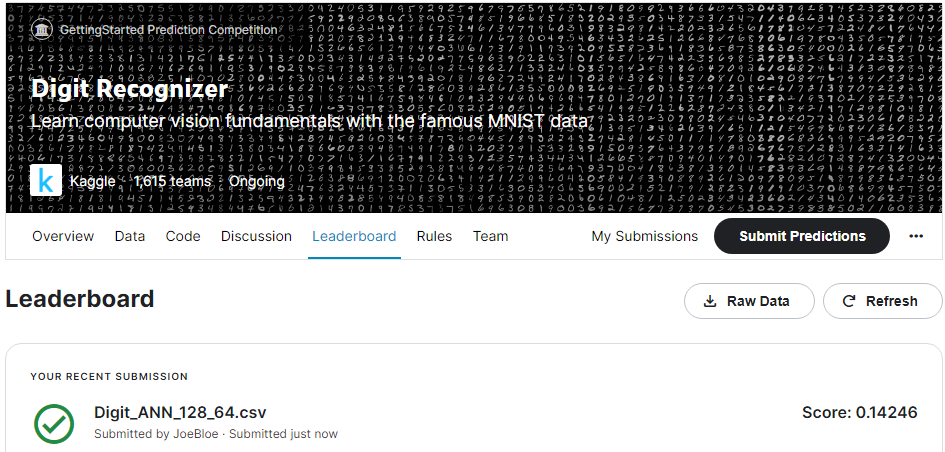